In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D,UpSampling2D, Input, Concatenate, Reshape
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import keras

from skimage.color import rgb2gray, gray2rgb

Using TensorFlow backend.


In [2]:
images=np.load("./dataset/images.npy")
masks=np.load("./dataset/masks.npy")

## Crop 512
images=images[:,34:546,34:546,:]

## Crop 512
masks=masks[:,34:546,34:546]

print(images.shape)
print(masks.shape)

#Normalization
images=images/np.max(images)
masks=masks/np.max(masks)

training_images = images[:19]
training_masks = masks[:19]
test_images = images[19:]
test_masks = masks[19:]

(20, 512, 512, 3)
(20, 512, 512)


In [3]:
def EncBlock(tensor,num,filters,down_scale_first=True):
    t=tensor
    if down_scale_first:
        t=MaxPooling2D((2,2))(t)
    for i in range(num):
        t=Conv2D(filters, (3, 3), padding='same')(t)
        t=BN()(t)
        t=Activation('relu')(t)
    return t

def DecBlock(prev_tensor,enc_tensor,num,filters,enclayer=None):
    t=prev_tensor
    t=UpSampling2D((2,2))(t)
    enc_tensor=CenterCrop(keras.backend.int_shape(enc_tensor)[1],keras.backend.int_shape(enc_tensor)[2])(enc_tensor)
    t=Concatenate(axis=3)([enc_tensor,t])
    for i in range(num):
        t=Conv2D(filters, (3, 3), padding='same')(t)
        t=BN()(t)
        t=Activation('relu')(t)
    return t

def EncDec(x0):
    ## End
    x1=EncBlock(x0,2,32,down_scale_first=False) #512
    x2=EncBlock(x1,2,64) #256
    x3=EncBlock(x2,2,128) #128
    x4=EncBlock(x3,2,256) #64
    x5=EncBlock(x4,2,512) #32
    
    ## Dec
    x6=DecBlock(x5,x4,0,256) #64
    x7=DecBlock(x6,x3,2,128) #128
    x8=DecBlock(x7,x2,2,64) #256
    x9=DecBlock(x8,x1,2,32) #512
    
    # Out
    out=Conv2D(1, (3, 3), padding='same')(x9)
    out=BN()(out)
    out=Activation('sigmoid')(out)
    
    return out

lin=Input((512,512,3))
lout=EncDec(lin)

model = Model(inputs=lin, outputs=lout)
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)
  
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

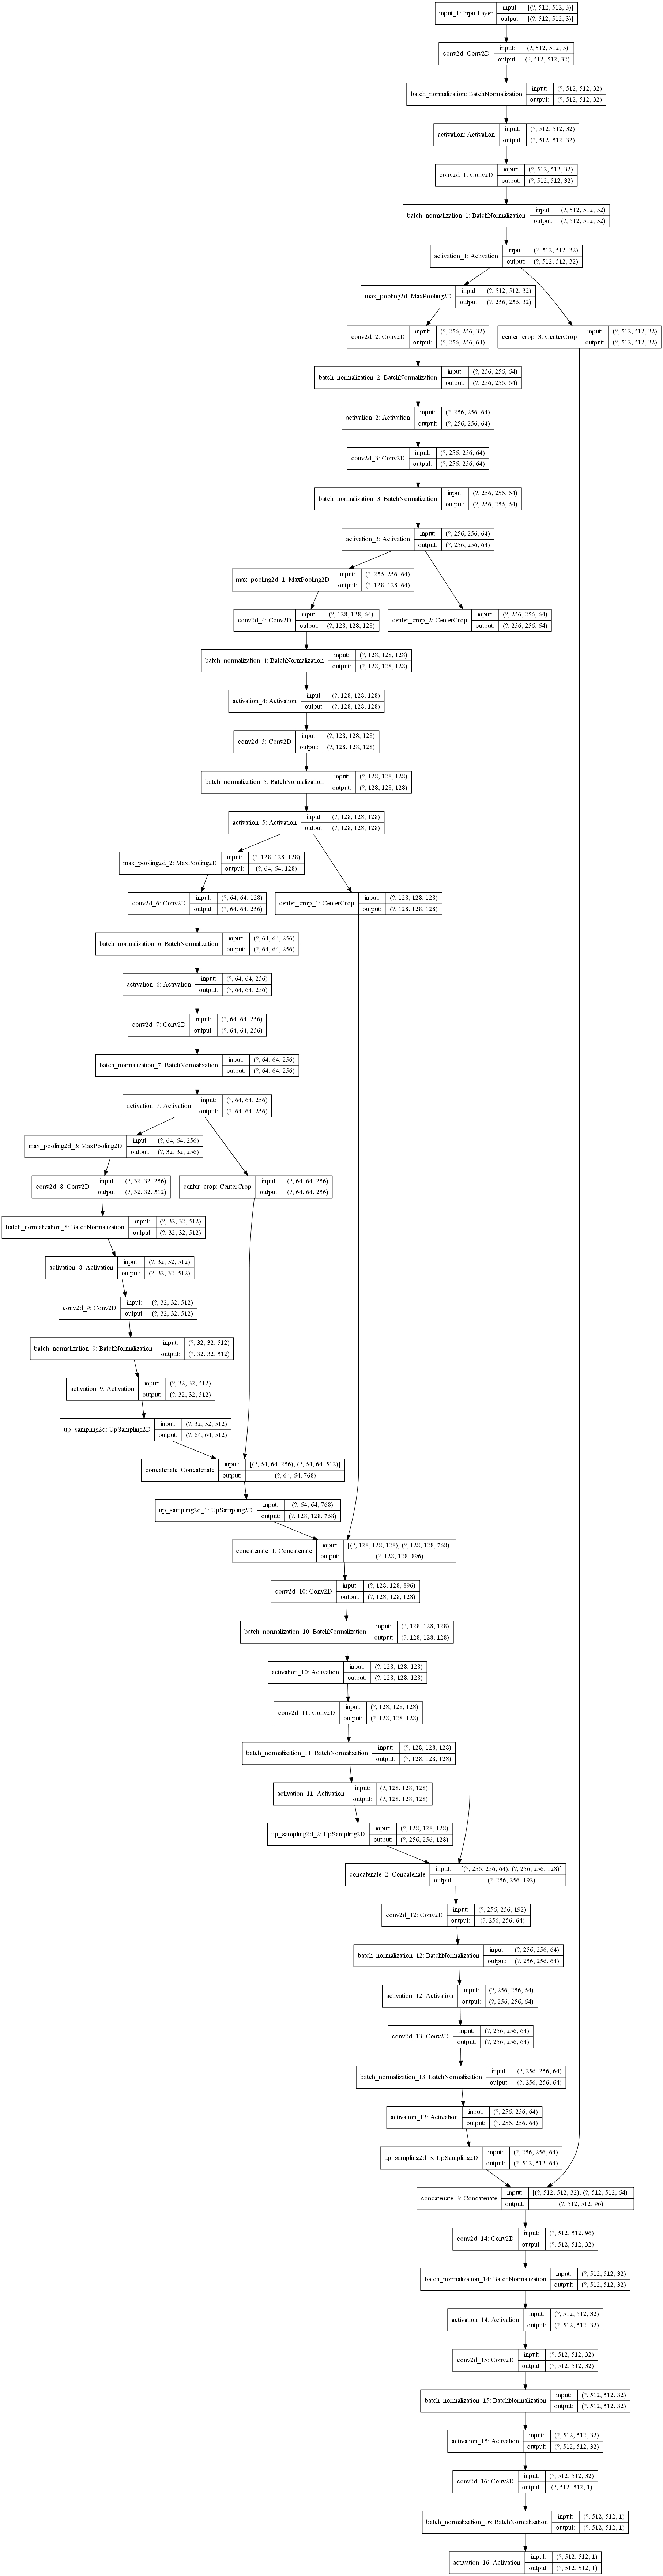

In [4]:
filename = 'model.png'

tf.keras.utils.plot_model(
    model,
    to_file=filename,
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

C:\Users\Admin\.conda\envs\rna\lib\site-packages\albumentations\augmentations\transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


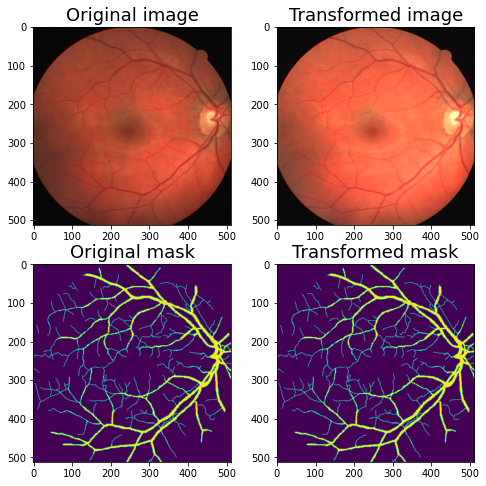

In [5]:
import albumentations as A
import cv2

def Visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 3, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
        ax[2].imshow(rgb2gray(image), cmap='gray')
        ax[2].imshow(mask, alpha=0.5)
        
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        
def Augmentor(img=None, mask=None):

    # Transformations applied only to image
    color_transform = A.Compose([
        A.RandomContrast(p=1.0, limit=(-0.75, 0.75)),
        #A.RandomBrightness(p=1.0, limit=(-0.2, 0.2))
    ])
    
    # Transformations applied to both image and mask
    shape_transform = A.Compose([])

    transformed = color_transform(image=img)
    transformed = shape_transform(image=transformed["image"],mask=mask)
    transformed_img = transformed["image"]
    transformed_mask = transformed["mask"]
    
    return transformed_img, transformed_mask

aug_img, aug_mask = Augmentor(images[0], masks[0])
Visualize(aug_img, aug_mask, original_image=images[0], original_mask=masks[0])

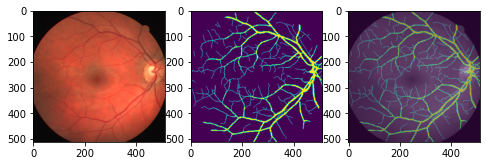

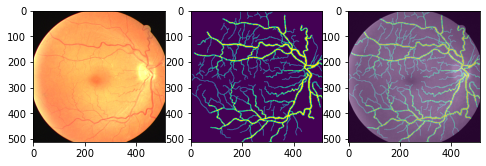

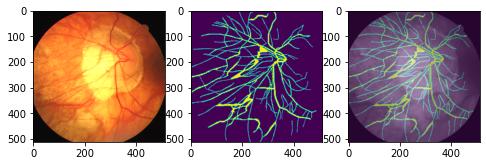

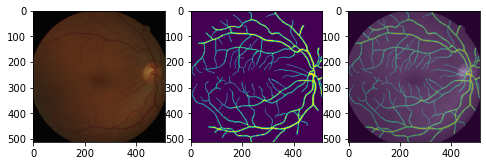

In [6]:
def DataGenerator(images, masks, batchsize):
    X = []
    Y = []
    batchcount = 0
    while True:
        for i in range(len(images)):
            # len(images) must be equal to len(masks)
            aug_img, aug_mask = Augmentor(img=images[i], mask=masks[i])
            X.append(aug_img)
            Y.append(aug_mask)
            batchcount += 1
            if batchcount > batchsize:
              X = np.array(X, dtype='float32')
              Y = np.array(Y, dtype='float32')
              yield (X, Y)
              X = []
              Y = []
              batchcount = 0
                
batch_size = 4
batch = next(DataGenerator(images, masks, batch_size))
for i in range(batch_size):
    Visualize(batch[0][i], batch[1][i])

In [7]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)

In [8]:
batch_size = 1
epochs = 200

opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['mse']) # metrica ideal para segmentacion: 'dice'

X = training_images
Y = training_masks

history = model.fit(
    DataGenerator(X, Y, batch_size),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=int(np.ceil(len(X)/batch_size)),
    verbose=1,
    callbacks=[checkpoint])

Epoch 1/200
19/19 [==============================] - 10s 536ms/step - loss: 0.6533 - mse: 0.2265
Epoch 2/200
19/19 [==============================] - 11s 555ms/step - loss: 0.5735 - mse: 0.1914
Epoch 3/200
19/19 [==============================] - 11s 555ms/step - loss: 0.5460 - mse: 0.1786
Epoch 4/200
19/19 [==============================] - 11s 555ms/step - loss: 0.5352 - mse: 0.1735
Epoch 5/200
19/19 [==============================] - 11s 555ms/step - loss: 0.5218 - mse: 0.1673
Epoch 6/200
19/19 [==============================] - 11s 555ms/step - loss: 0.5098 - mse: 0.1616
Epoch 7/200
19/19 [==============================] - 11s 555ms/step - loss: 0.5005 - mse: 0.1573
Epoch 8/200
19/19 [==============================] - 11s 555ms/step - loss: 0.4888 - mse: 0.1520
Epoch 9/200
19/19 [==============================] - 11s 555ms/step - loss: 0.4811 - mse: 0.1483
Epoch 10/200
19/19 [==============================] - 11s 555ms/step - loss: 0.4746 - mse: 0.1452
Epoch 11/200
19/19 [=========

19/19 [==============================] - 11s 555ms/step - loss: 0.3260 - mse: 0.0820
Epoch 33/200
19/19 [==============================] - 11s 555ms/step - loss: 0.3204 - mse: 0.0798
Epoch 34/200
19/19 [==============================] - 11s 555ms/step - loss: 0.3148 - mse: 0.0777
Epoch 35/200
19/19 [==============================] - 11s 555ms/step - loss: 0.3082 - mse: 0.0753
Epoch 36/200
19/19 [==============================] - 11s 555ms/step - loss: 0.3037 - mse: 0.0735
Epoch 37/200
19/19 [==============================] - 11s 555ms/step - loss: 0.2993 - mse: 0.0720
Epoch 38/200
19/19 [==============================] - 11s 557ms/step - loss: 0.2955 - mse: 0.0705
Epoch 39/200
19/19 [==============================] - 11s 557ms/step - loss: 0.2915 - mse: 0.0690
Epoch 40/200
19/19 [==============================] - 11s 557ms/step - loss: 0.2865 - mse: 0.0672
Epoch 41/200
19/19 [==============================] - 11s 557ms/step - loss: 0.2828 - mse: 0.0659
Epoch 42/200
19/19 [=============

19/19 [==============================] - 11s 557ms/step - loss: 0.1968 - mse: 0.0378
Epoch 65/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1881 - mse: 0.0349
Epoch 66/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1831 - mse: 0.0333
Epoch 67/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1822 - mse: 0.0331
Epoch 68/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1817 - mse: 0.0331
Epoch 69/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1791 - mse: 0.0324
Epoch 70/200
19/19 [==============================] - 11s 558ms/step - loss: 0.1793 - mse: 0.0326
Epoch 71/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1745 - mse: 0.0312
Epoch 72/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1681 - mse: 0.0292
Epoch 73/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1685 - mse: 0.0294
Epoch 74/200
19/19 [=============

19/19 [==============================] - 11s 557ms/step - loss: 0.1159 - mse: 0.0158
Epoch 97/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1137 - mse: 0.0152
Epoch 98/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1120 - mse: 0.0149
Epoch 99/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1114 - mse: 0.0148
Epoch 100/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1098 - mse: 0.0146
Epoch 101/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1081 - mse: 0.0141
Epoch 102/200
19/19 [==============================] - 11s 557ms/step - loss: 0.1064 - mse: 0.0138
Epoch 103/200
19/19 [==============================] - 23s 1s/step - loss: 0.1059 - mse: 0.0138
Epoch 104/200
19/19 [==============================] - 31s 2s/step - loss: 0.1044 - mse: 0.0135
Epoch 105/200
19/19 [==============================] - 11s 555ms/step - loss: 0.1018 - mse: 0.0127
Epoch 106/200
19/19 [============

19/19 [==============================] - 11s 557ms/step - loss: 0.0732 - mse: 0.0070
Epoch 129/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0734 - mse: 0.0073
Epoch 130/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0725 - mse: 0.0071
Epoch 131/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0706 - mse: 0.0067
Epoch 132/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0701 - mse: 0.0066
Epoch 133/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0681 - mse: 0.0061
Epoch 134/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0664 - mse: 0.0057
Epoch 135/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0656 - mse: 0.0055
Epoch 136/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0631 - mse: 0.0049
Epoch 137/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0613 - mse: 0.0044
Epoch 138/200
19/19 [===

19/19 [==============================] - 11s 557ms/step - loss: 0.0452 - mse: 0.0023
Epoch 161/200
19/19 [==============================] - 11s 559ms/step - loss: 0.0446 - mse: 0.0022
Epoch 162/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0441 - mse: 0.0021
Epoch 163/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0436 - mse: 0.0021
Epoch 164/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0431 - mse: 0.0020
Epoch 165/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0426 - mse: 0.0020
Epoch 166/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0421 - mse: 0.0020
Epoch 167/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0417 - mse: 0.0019
Epoch 168/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0412 - mse: 0.0019
Epoch 169/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0407 - mse: 0.0018
Epoch 170/200
19/19 [===

19/19 [==============================] - 11s 557ms/step - loss: 0.0636 - mse: 0.0111
Epoch 193/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0701 - mse: 0.0133
Epoch 194/200
19/19 [==============================] - 11s 557ms/step - loss: 0.0611 - mse: 0.0105
Epoch 195/200
19/19 [==============================] - 11s 558ms/step - loss: 0.0518 - mse: 0.0076
Epoch 196/200
19/19 [==============================] - 11s 558ms/step - loss: 0.0494 - mse: 0.0070
Epoch 197/200
19/19 [==============================] - 31s 2s/step - loss: 0.0496 - mse: 0.0071
Epoch 198/200
19/19 [==============================] - 17s 910ms/step - loss: 0.0445 - mse: 0.0055
Epoch 199/200
19/19 [==============================] - 11s 555ms/step - loss: 0.0398 - mse: 0.0040
Epoch 200/200
19/19 [==============================] - 11s 555ms/step - loss: 0.0354 - mse: 0.0027


Text(0.5, 1.0, 'Predicted mask')

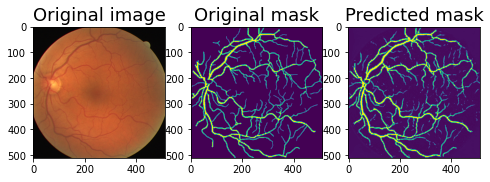

In [9]:
predicted=model.predict(test_images)

fontsize = 18
f, ax = plt.subplots(1, 3, figsize=(8, 8), squeeze=False)

ax[0, 0].imshow(test_images[0])
ax[0, 0].set_title('Original image', fontsize=fontsize)

ax[0, 1].imshow(test_masks[0])
ax[0, 1].set_title('Original mask', fontsize=fontsize)

ax[0, 2].imshow(predicted[0])
ax[0, 2].set_title('Predicted mask', fontsize=fontsize)

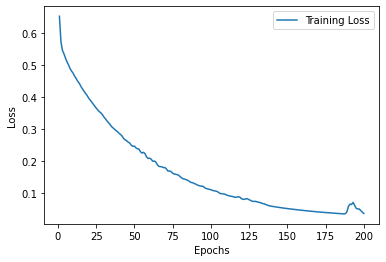

In [10]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()